## Sentiment analysis with few plots for the EDA

In [3]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
df = pd.read_csv('data.csv')
df['Title'] = df['Title'].astype(str)
df['Body'] = df['Body'].astype(str)

In [5]:
list_title = df['Title'].to_list()
stopwords = nltk.corpus.stopwords.words('italian')
words_title = [word for text in list_title for word in nltk.word_tokenize(text)]
words_title_clear = [w for w in words_title if w not in stopwords]

## Most common words in titles and bodies

In [6]:
fd_title = nltk.FreqDist(words_title_clear)

sorted_fd_title = dict(sorted(fd_title.items(), key=lambda item: item[1], reverse=True))

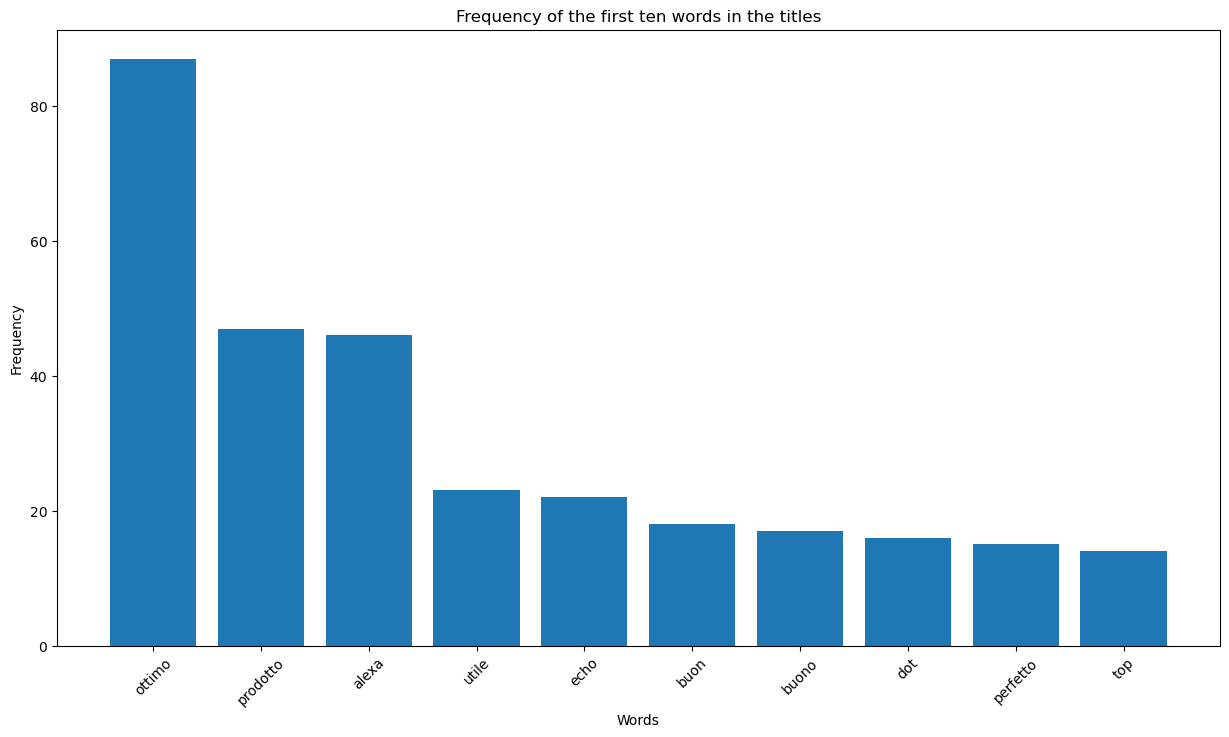

In [7]:
plt.figure(figsize=(15,8))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Frequency of the first ten words in the titles')
plt.bar(list(sorted_fd_title.keys())[:10], list(sorted_fd_title.values())[:10])
plt.show()

In [8]:
list_body = df['Body'].to_list()
list_body = [str(word) for word in list_body]
words_body = [word for text in list_body for word in nltk.word_tokenize(text)]
words_body_clear = [w for w in words_body if w.lower() not in stopwords]

In [9]:
fd_body = nltk.FreqDist(words_body_clear)

sorted_fd_body = dict(sorted(fd_body.items(), key=lambda item: item[1], reverse=True))

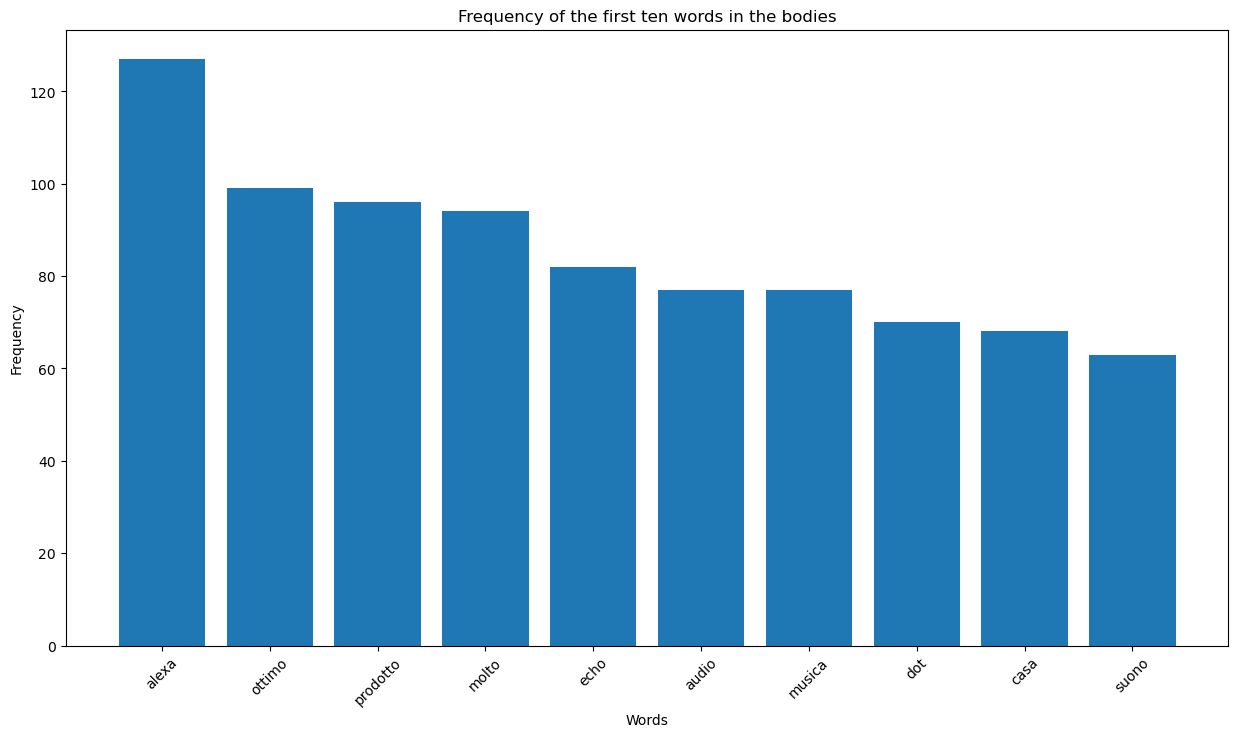

In [10]:
plt.figure(figsize=(15,8))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Frequency of the first ten words in the bodies')
plt.bar(list(sorted_fd_body.keys())[:10], list(sorted_fd_body.values())[:10])
plt.show()

## Word Plots for positive and neutral reviews

In [11]:
positive_reviews = df[df['Stars'] >= 4]['Title']
positive_reviews = ".".join(positive_reviews)

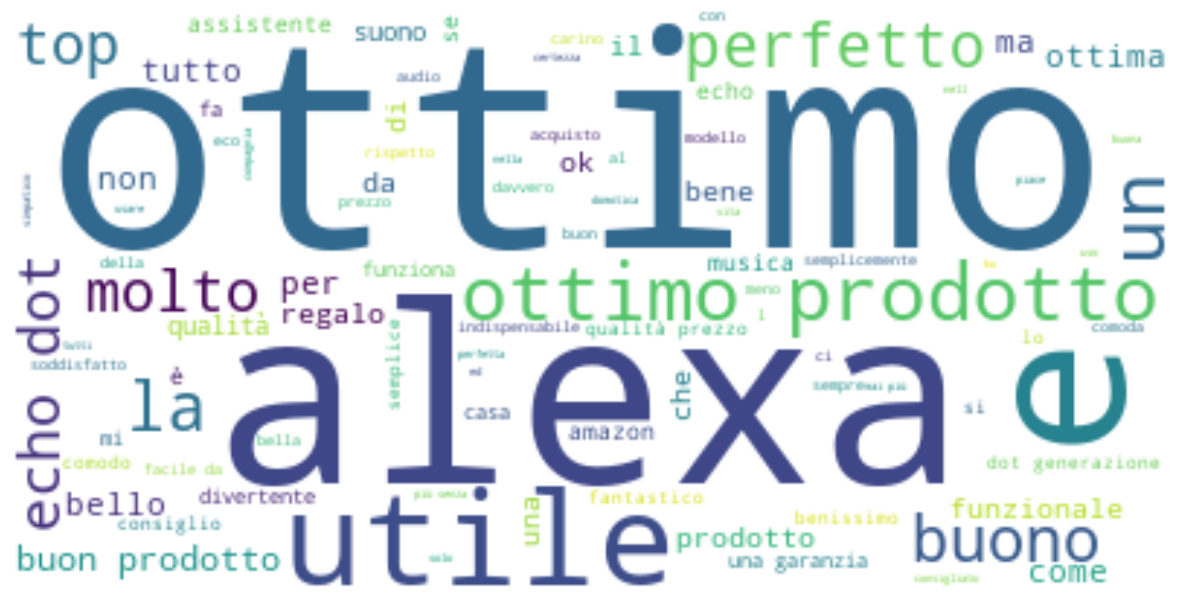

In [12]:
wordcloud = WordCloud(background_color="white", max_words=len(positive_reviews))

wordcloud.generate(positive_reviews)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
neutral_reviews = df[df['Stars'] == 3]['Title']
neutral_reviews = ".".join(neutral_reviews)

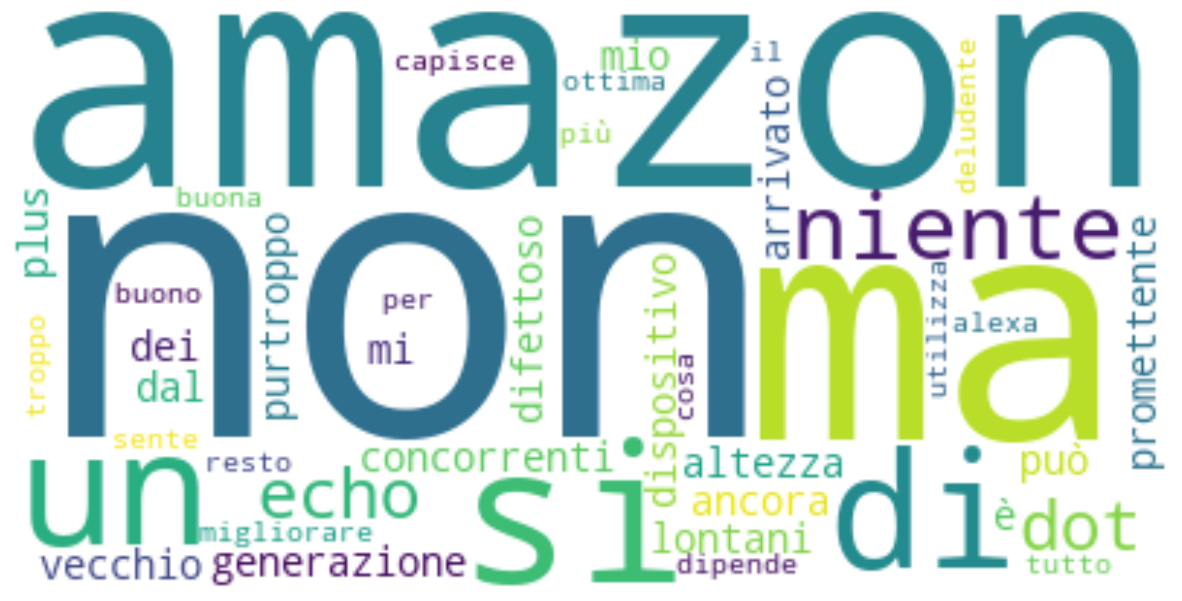

In [14]:
wordcloud = WordCloud(background_color="white", max_words=len(neutral_reviews))

wordcloud.generate(neutral_reviews)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Review classification

In [15]:
sia = SentimentIntensityAnalyzer()
title_polarity = [sia.polarity_scores(str(element)) for element in df['Title']]
body_polarity = [sia.polarity_scores(str(element)) for element in df['Body']]

In [16]:
title_pol_mean = []

for i in range(len(title_polarity)):
    if title_polarity[i]['compound'] == 0.0:
        title_pol_mean.append(0.5)
    else:
        title_pol_mean.append(title_polarity[i]['compound'])

In [17]:
body_pol_mean = []

for i in range(len(body_polarity)):
    if body_polarity[i]['compound'] == 0.0:
        body_pol_mean.append(0.5)
    else:
        body_pol_mean.append(body_polarity[i]['compound'])

In [18]:
total_polarity = []
total_polarity = [round((i*0.2 + j*0.8)/2, 4) for i,j in zip(title_pol_mean, body_pol_mean)] # usually you should weight the title more since it explains better 
                                                                                             # the polarity of the review but since my titles were all neutral I decided to weight them less

In [19]:
df['Polarity'] = total_polarity

In [20]:
list_polarity = []
for i in range(len(df)):
    if df['Polarity'][i] < 0:
        list_polarity.append('Bad')
    elif df['Polarity'][i] <= 0.15:
        list_polarity.append('Neutral')
    else:
        list_polarity.append('Good')

df['Polarity_Text'] = list_polarity

In [21]:
df['Polarity_Text'].value_counts()

Good       397
Bad         65
Neutral     38
Name: Polarity_Text, dtype: int64

In [22]:
df['Full Review'] = df.apply(lambda row: row['Title'] + ' ' + row['Body'], axis=1)

## Dense Matrix to feed the models

In [23]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['Full Review'])
feature_names = vectorizer.get_feature_names_out()
matrix = vectors.todense()
list_dense = matrix.tolist()
sparse_matrix = pd.DataFrame(list_dense, columns=feature_names)

In [24]:
sparse_matrix['Polarity_Text'] = list_polarity

In [25]:
sparse_matrix.shape

(500, 2590)

In [26]:
df.to_csv('data_final.csv', index=False)